## 1. 단어의 표현 방법
머신러닝 등의 알고리즘이 적용된 본격적인 자연어 처리를 위해서는 문자를 숫자로 수치화해야 한다.        
- 국소 표현(Local Representation) = 이산 표현(Discrete Representation)        
해당 단어 그 자체만 보고 특정값을 매핑하여 표현
- 분산 표현(Distributed Representation) = 연속 표현(Continuous Representation)      
해당 단어를 표현하고자 주변을 참고하여 단어를 표현하는 방법.
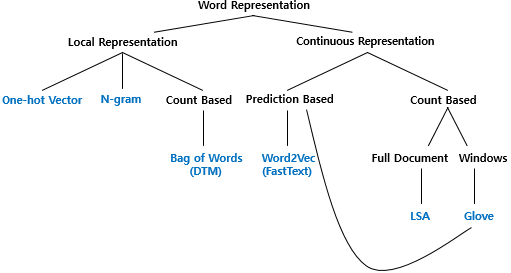
- 챕터 4: Bag of Words, DTM
- 챕터 6: LSA(토픽 모델링)
- 챕터 10: Word2Vec, FastText, GloVe

## 2. Bag of Words(BoW)

### 1) Bag of Words란?
단어들의 순서는 전혀 고려하지 않고 출현 빈도(frequency)에만 집중하는 텍스트 데이터의 수치화 표현방법.           
주로 어떤 단어가 얼마나 등장했는지를 기준으로 문서가 어떤 성격의 문서인지 판단할 때 쓰인다.     
(1) 각 단어에 고유한 정수 인덱스 부여      
(2) 각 인덱스 위치에 단어 토큰의 등장 횟수를 기록한 벡터 생성

예) 정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다.

In [1]:
from konlpy.tag import Okt
import re
okt=Okt()

In [3]:
# 정규표현식을 이용해서 온점 제거
token = re.sub("(\.)", "", "정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다.")

# okt 형태소 분석기를 이용하여 token화
token = okt.morphs(token)


word2index={}
bow=[]
for voca in token:
    if voca not in word2index.keys():
        #word2index에 없는 단어 새로 추가
        word2index[voca]=len(word2index) 
        #insert: 리스트 내 (첫번째 인자)번째 요소에 (두번째 인자)값 추가하기
        bow.insert(len(word2index)-1, 1)   # 기본값으로 1
        
    else:
        index=word2index.get(voca)  #voca에 대응되는 dictionary의 value
        bow[index]= bow[index]+1 # 해당 위치에 1 더하기 -> 단어 개수 세기
        
print(word2index) # unique한 토큰들의 index
print(bow) # 각 token이 몇번 나오는지

{'정부': 0, '가': 1, '발표': 2, '하는': 3, '물가상승률': 4, '과': 5, '소비자': 6, '느끼는': 7, '은': 8, '다르다': 9}
[1, 2, 1, 1, 2, 1, 1, 1, 1, 1]


### 2) 사이킷런의 CountVectorizer 클래스로 BoW 만들기

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

corpus=['you know I want your love. because I love you.']
vector=CountVectorizer()
print(vector.fit_transform(corpus).toarray()) # 각 단어의 빈도수 기록
print(vector.vocabulary_) # 각 단어에 인덱스가 어떻게 부여되어있는지

[[1 1 2 1 2 1]]
{'you': 4, 'know': 1, 'want': 3, 'your': 5, 'love': 2, 'because': 0}


- CountVectorizer는 기본적으로 길이가 2 이상인 문자만 토큰으로 인식해서 I는 빠졌다!
- 띄어쓰기를 기준으로 단어를 분리하므로, 한국어는 힘들듯하다 (예: '물가상승률과' 와 '물가상승률은' 을 두 단어로 인식함)

### 3) 불용어를 제거한 BoW 만들기

#### 사용자가 직접 정의한 불용어 사용

In [7]:
text=["Family is not an important thing. It's everything."]
vect=CountVectorizer(stop_words=["the", "a", "an", "is", "not"])
print(vect.fit_transform(text).toarray())
print(vect.vocabulary_)

[[1 1 1 1 1]]
{'family': 1, 'important': 2, 'thing': 4, 'it': 3, 'everything': 0}


#### CountVectorizer에서 제공하는 자체 불용어 사용

In [8]:
text=["Family is not an important thing. It's everything."]
vect=CountVectorizer(stop_words="english")
print(vect.fit_transform(text).toarray())
print(vect.vocabulary_)

[[1 1 1]]
{'family': 0, 'important': 1, 'thing': 2}


#### NLTK에서 지원하는 불용어 사용

In [9]:
from nltk.corpus import stopwords

text=["Family is not an important thing. It's everything."]
sw = stopwords.words("english")
vect = CountVectorizer(stop_words =sw)
print(vect.fit_transform(text).toarray()) 
print(vect.vocabulary_)

[[1 1 1 1]]
{'family': 1, 'important': 2, 'thing': 3, 'everything': 0}


## 3. 문서 단어 행렬(Document-Term Matrix, DTM)

### 1) DTM의 표기법
- 문서 단어 행렬: 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현한 것.(각 문서에 대한 BoW를 하나의 행렬로 만듦.)
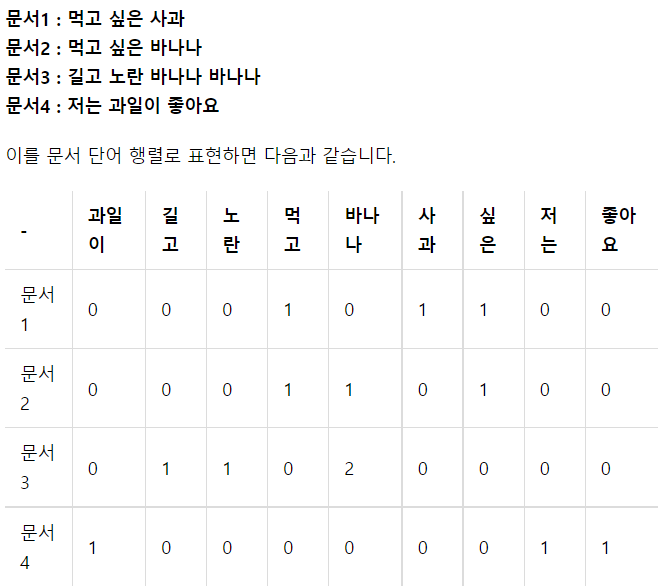
문서들을 서로 비교할 수 있도록 수치화할 수 있다.

### 2) DTM의 한계
#### (1) 희소 표현(Sparse representation)
전체 단어집합의 크기를 차원으로 가지고 대부분의 값이 0 => 공간적 낭비, 계산 리소스 증가        
=> 전처리를 통해 단어집합의 크기를 줄이는 과정이 필요함.(구두점, 빈도수가 낮은 단어, 불용어 제거, 어간 및 표제어 추출 등)       
#### (2) 단순 빈도수 기반 접근
각 문서에는 중요한 단어와 불필요한 단어가 혼재되어 있음.__(이러한 단점을 극복하기 위해 사용하는 것이 TF-IDF!!)__

## 4. TF-IDF (Term Frequency-Inverse Document Frequency)

### 1) TF-IDF (Term Frequency-Inverse Document Frequency, 단어 빈도-역 문서 빈도)
- 단어 빈도와 역 문서 빈도(문서의 빈도에 특정 식을 취함)를 사용하여 DTM 내 각 단어들마다 중요한 정도를 가중치로 주는 방법.     
DTM을 만든 후 TF-IDF 가중치를 부여하는 순서로 진행된다.        
- 주로 문서의 유사도 구할때, 검색 시스템에서 검색 결과의 중요도를 정할 때, 문서 내에서 특정 단어의 중요도를 구할 때 등에 쓰인다.
- TF-IDF는 TF와 IDF를 곱한다는 의미.       
문서:d, 단어:t, 문서의 총 개수:n이라고 할 때        
    1. tf(d,t): 특정 문서 d에서의 특정 단어 t 등장 횟수.       
    DTM에서 각 단어들이 가진 값과 같다.
    1. df(t): 특정 단어 t가 등장한 문서의 수.  
    등장한 총 횟수랑은 상관없이 등장한 문서의 수만 집계!
    1. idf(d,t): df(t)에 반비례하는 수
    $idf(d,t)=log(n/(1+df(t)))$              
    이때 log는 문서 수 n이 커질 때 IDF값이 기하급수적으로 커지는 것을 막고, 희귀 단어에 엄청난 가중치가 부여되는 것을 방지한다.        
    __TF-IDF는 모든 문서에서 자주 등장하는 단어는 중요도가 낮고, 특정 문서에만 자주 등장하는 단어는 중요도가 높다고 판단한다.__
          
예) 3.의 DTM 예시에 대한 IDF
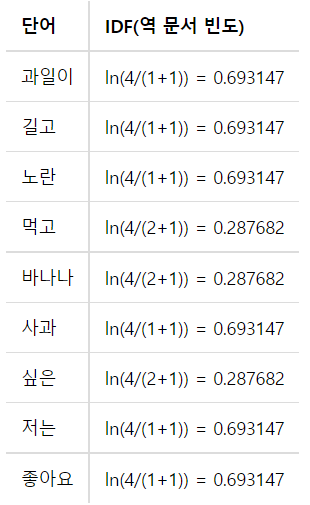
문서 2개에서 등장한 단어의 경우 가중치가 낮아진다!        
            
DTM에서 TF를 가져올 수 있으므로, DTM에서 단어별로 IDF값을 곱해준다.
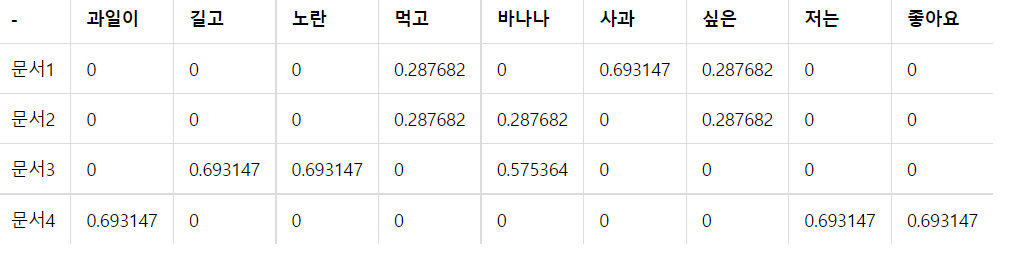
- 문서2와 문서3의 바나나에 대한 가중치가 다른데, 문서2는 한번 언급하고 3에서는 두번 언급하기 때문에 문서 3에서의 바나나를 더욱 중요한 단어라고 판단하기 때문.

### 2) TF-IDF 구현

In [1]:
import pandas as pd
from math import log

In [2]:
# 4개의 문서를 docs에 저장
docs = [
  '먹고 싶은 사과',
  '먹고 싶은 바나나',
  '길고 노란 바나나 바나나',
  '저는 과일이 좋아요'
]

vocab = list(set(w for doc in docs for w in doc.split())) # split 디폴트: 띄어쓰기
vocab.sort()

In [3]:
vocab

['과일이', '길고', '노란', '먹고', '바나나', '사과', '싶은', '저는', '좋아요']

In [6]:
# tf. idf. tf-idf 값을 구하는 함수 구현
N = len(docs)

def tf(t,d):
    return d.count(t)

def idf(t):
    df = 0
    for doc in docs:
        df += t in doc  #doc 안에 있으면 집계
    return log(N/(df+1))

def tfidf(t,d):
    return tf(t,d)*idf(t)

In [7]:
# tf 구하기 (dtm을 데이터프레임에 저장하여 출력)
result=[]
for i in range(N):  # 문서마다 수행
    result.append([])
    d = docs[i]
    for j in range(len(vocab)):
        t=vocab[j]
        result[-1].append(tf(t,d))
        
tf_ = pd.DataFrame(result, columns=vocab)
tf_

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0,0,0,1,0,1,1,0,0
1,0,0,0,1,1,0,1,0,0
2,0,1,1,0,2,0,0,0,0
3,1,0,0,0,0,0,0,1,1


In [8]:
# 각 단어의 idf 구하기
result=[]
for j in range(len(vocab)):
    t=vocab[j]
    result.append(idf(t))
    
idf_ = pd.DataFrame(result, index=vocab, columns=["IDF"])
idf_

,IDF
과일이,0.693147
길고,0.693147
노란,0.693147
먹고,0.287682
바나나,0.287682
사과,0.693147
싶은,0.287682
저는,0.693147
좋아요,0.693147


In [11]:
# if-idf 행렬 출력
result=[]
for i in range(N):
    result.append([])
    d=docs[i]
    for j in range(len(vocab)):
        t=vocab[j]
        result[-1].append(tfidf(t,d))
        
tfidf_ = pd.DataFrame(result, columns=vocab)
tfidf_

,과일이,길고,노란,먹고,바나나,사과,싶은,저는,좋아요
0,0.000000,0.000000,0.000000,0.287682,0.000000,0.693147,0.287682,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.287682,0.287682,0.000000,0.287682,0.000000,0.000000
2,0.000000,0.693147,0.693147,0.000000,0.575364,0.000000,0.000000,0.000000,0.000000
3,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147


위의 식을 바탕으로 했을 때 문제점이 존재하기 때문에 실제 tf-idf 구현을 제공하는 패키지에서는 기본 식에서 조정된 식을 많이 사용함.      
예) 전체 문서 수가 4개인데 df(t)의 값이 3인 경우, log항의 분자 분모값이 같아져서 1이 되고 idf(d,t)이 0이 된다.

### 3) scikit learn을 이용한 DTM과 df-idf 실습
위에서 말한 문제점을 극복하기 위해,       
$idf(d,t)=log(n/(df(t)+1))+1$ 로 계산해서 log항의 값이 0이 되더라도 idf값이 최소 1 이상의 값을 갖게 한다.

In [12]:
# CountVectorizer를 이용하여 DTM 만들기
from sklearn.feature_extraction.text import CountVectorizer

corpus = [
    'you know I want your love',
    'I like you',
    'what should I do ',    
]

vector = CountVectorizer()
print(vector.fit_transform(corpus).toarray()) #corpus로부터 각 빈도수 기록
print(vector.vocabulary_) # 각 단어의 인덱스

[[0 1 0 1 0 1 0 1 1]
 [0 0 1 0 0 0 0 1 0]
 [1 0 0 0 1 0 1 0 0]]
{'you': 7, 'know': 1, 'want': 5, 'your': 8, 'love': 3, 'like': 2, 'what': 6, 'should': 4, 'do': 0}


=> 첫번째 열은 0번째 인덱스를 가진 do에 해당.

#### TfidfVectorizer 사용: L2 정규화를 이용해서 값을 조정한다.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'you know I want your love',
    'I like you',
    'what should I do ',    
]

tfidfv = TfidfVectorizer().fit(corpus)
print(tfidfv.transform(corpus).toarray())
print(tfidfv.vocabulary_)

[[0.         0.46735098 0.         0.46735098 0.         0.46735098
  0.         0.35543247 0.46735098]
 [0.         0.         0.79596054 0.         0.         0.
  0.         0.60534851 0.        ]
 [0.57735027 0.         0.         0.         0.57735027 0.
  0.57735027 0.         0.        ]]
{'you': 7, 'know': 1, 'want': 5, 'your': 8, 'love': 3, 'like': 2, 'what': 6, 'should': 4, 'do': 0}
